# Batch Crystalliser in Pyomo: Model-based selection of experiments

Cameron Brown (cameron.brown.100@strath.ac.uk), Aaron Bjarnason (aaron.bjarnason@strath.ac.uk), Alex Dowling (adowling@nd.edu), Hailey Lynch (hlynch@nd.edu), Dan Laky (dlaky@nd.edu)


This file:
 1. Simulates crystallization experiments, and adds measurement noise to the data (prior data).
 2. Estimates the kinetic parameters using prior data (parmest).
 3. Considers a list of experiments and uses FIM to estimate which one might give most information about parameter set. 
 4. Iterates on this process: which experiment gives best (D-optimal) projected information content > Re-estimate parameter set > Remove completed experiment from list > Find new optimal experiment > Re-estimate...

 Requires files: 'Cryst_model_plot.py', 'Design of Experiments.xlsx'


## Setup Environment

In [1]:
# Imports

import sys

import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import pyomo.environ as pyo
from pyomo.dae import *
from pyomo.contrib.doe import (ModelOptionLib, DesignOfExperiments, MeasurementVariables, DesignVariables)

# Function files - newly separated from main body
# from Cryst_model_MB_SoE import *
# from Cryst_model import *
from Cryst_model_plot import *
# from Cryst_model_parmest import *

from colorama import Fore, Back, Style

## Define Typical Experiment and Model

Now within Cryst_model.py

In [2]:
def typical_experiment(beta=0.1/60):
  '''
  This function defines a typical experiment for batch crystallization

  Outputs:
  exp_conditions: returns dictionary of experimental conditions
  '''
  # Empty dictionary for experimental condtions
  exp_conditions = {}

  # Experimental parameters (Ci, Ti, tau, beta, eps, M_seed, Ls)

  exp_conditions['Ci'] = 116.68 * 1e-3  # initial concentration [g.cm-3]
  #exp_conditions['Ci'] = 112.68 * 1e-3 # different option

  exp_conditions['Ti'] = 323.9          # initial temperature [K]

  exp_conditions['tau'] = 7200          # process duration [s]

  # exp_conditions['beta'] = 0         
  exp_conditions['beta'] = beta         # cooling rate [K/s]

  exp_conditions['eps'] = 0.5 * 1e-3    # power density [W / g cryst
  
  #   exp_conditions['M_seed'] = 2.4 * 1e-3     # initial seed concentration [g.cm-3]
  exp_conditions['M_seed'] = 0          # initial seed concentration [kg.m-3], [g.cm-3]

  exp_conditions['Ls'] = 2e-5 * 1e3     # seed size [mm]

  return exp_conditions


In [3]:
# Creating the model for simulations using theta_est
def model_theta_switch(mod=None, model_option='parmest', exp_conditions=typical_experiment(), time_points=None):
    '''
    Create a Concrete Pyomo model for the crystallization problem

    We are debugging this model now. For parameter estimation and MBDoE,
    this function will be very helpful.

    Inputs:
    mod: model; set to None
    model_option: model option; choose between stage1, stage2, parmest
    exp_conditions: experimental conditions
    time_points: time points; set to None

    Outputs:
    m: Pyomo model
    '''

    ## Build the model ##
    # m = pyo.ConcreteModel()
    m=mod

    ## Model option ##
    model_option = ModelOptionLib(model_option)

    if model_option == ModelOptionLib.parmest:
        m = pyo.ConcreteModel()
        #print('created model')
        return_m = True
    elif model_option == ModelOptionLib.stage1 or model_option == ModelOptionLib.stage2:
        if not mod:
            raise ValueError(
                "If model option is stage1 or stage2, a created model needs to be provided."
            )
        return_m = False
    else:
        raise ValueError(
            "model_option needs to be defined as parmest, stage1, or stage2."
        )

    ## Fixed parameters ##

    # These parameters are not changing
    rho     = 1360 * 1e-6       # crystal density [g.mm-3]
    kv      = 0.523             # volume shape factor
    C1      = 2.209e-6 * 1e-3   # solubility parameter 1 (for g.cm-3)
    C2      = 5.419e-2          # solubility parameter 2

    # Establishing non-dimensional time parameter (i.e., t=tau*t_f)
    m.tau = exp_conditions['tau']

    ## Scaling parameters ##
    m.mu0_scale      = 1e5
    m.mu1_scale      = 1e4
    m.mu2_scale      = 1e2
    m.mu3_scale      = 1e1
    m.mu4_scale      = 1e0
    # m.B_scale        = 1e1
    # m.B_scale        = 1e2  # May change this back
    m.Bp_scale       = 1e1  # Primary nucl. scaling
    m.Bs_scale       = 1e2  # Seconday nucl. scaling
    m.G_scale        = 1e-5

    ## Fitting parameters ##
    # These are the parameters we are using for parameter estimation
    if expt_selection == True:  # Use estimated parameter set
        if theta_est is not None:
            m.theta = theta_est # If we have previous values for theta^
        else:                   # Initial guess
            m.theta = {'kb1': 5e2, 'b1': 1, 'kb2': 2e8, 'b2': 2, 'kg': 3e-4, 'g': 1}
    else:                       # Use true parameter values: experimental data
        m.theta = {'kb1': 1e2, 'b1': 1, 'kb2': 1e9, 'b2': 2, 'kg': 2e-4, 'g': 1} # kb1 to unit 1/mL, kb2 does not have units changed due to balance on epsilon units, kg changed to mm/s. Unit conversions added

    ## Time ##
    m.t0 = pyo.Set(initialize=[0]) # Initial time
    if time_points is not None:
        # Do not specify time points
        # m.t = ContinuousSet(bounds=(0, 1)) # Time set
        m.t = ContinuousSet(bounds=(0, m.tau)) # Time set
    else:
        # m.t = ContinuousSet(bounds=(0, 1), initialize=time_points) # Time set
        m.t = ContinuousSet(bounds=(0, m.tau), initialize=time_points) # Time set

    ## Initial Conditions ##
    # Declare data used for only initial conditions

    c_sat = 1.01*C1*np.exp(C2*exp_conditions['Ti'])

    # Concentration
    m.Ci = pyo.Param(m.t0, initialize = exp_conditions['Ci'], within = pyo.NonNegativeReals)
    # m.Ci = pyo.Var(m.t0, initialize=c_sat, within=pyo.NonNegativeReals)

    # Temperature
    # m.Ti = pyo.Param(m.t0, initialize = exp_conditions['Ti'], within = pyo.NonNegativeReals)
    m.Ti = pyo.Var(m.t0, initialize = exp_conditions['Ti'], within = pyo.NonNegativeReals)

    # Epsilon
    m.eps = pyo.Param(m.t0, initialize = exp_conditions['eps'], within = pyo.NonNegativeReals)

    # M seed
    # m.M_seed = pyo.Param(m.t0, initialize = exp_conditions['M_seed'], within = pyo.NonNegativeReals)
    m.M_seed = pyo.Var(m.t0, initialize = exp_conditions['M_seed'], within = pyo.NonNegativeReals)

    # Ls
    m.Ls = pyo.Param(m.t0, initialize = exp_conditions['Ls'], within = pyo.NonNegativeReals)

    # Beta
    # For now, assume constant scaling
    m.beta = pyo.Var(m.t0, initialize = exp_conditions['beta'], within = pyo.NonNegativeReals)

    ## Declare pyo.Variables ##
    # m.mu0 = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    m.mu0 = pyo.Var(m.t, initialize = exp_conditions['M_seed']/(rho*kv*exp_conditions['Ls']**3)/m.mu0_scale, within = pyo.NonNegativeReals)
    # m.mu1 = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    m.mu1 = pyo.Var(m.t, initialize = exp_conditions['M_seed']/(rho*kv*exp_conditions['Ls']**4)/m.mu1_scale, within = pyo.NonNegativeReals)
    # m.mu2 = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    m.mu2 = pyo.Var(m.t, initialize = exp_conditions['M_seed']/(rho*kv*exp_conditions['Ls']**5)/m.mu2_scale, within = pyo.NonNegativeReals)
    # m.mu3 = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    m.mu3 = pyo.Var(m.t, initialize = exp_conditions['M_seed']/(rho*kv*exp_conditions['Ls']**6)/m.mu3_scale, within = pyo.NonNegativeReals)
    # m.mu4 = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    m.mu4 = pyo.Var(m.t, initialize = exp_conditions['M_seed']/(rho*kv*exp_conditions['Ls']**7)/m.mu4_scale, within = pyo.NonNegativeReals)

    m.C     = pyo.Var(m.t, initialize = exp_conditions['Ci'],       within = pyo.NonNegativeReals)
    m.MT    = pyo.Var(m.t, initialize = exp_conditions['M_seed'],   within = pyo.NonNegativeReals)
    m.T     = pyo.Var(m.t, initialize = exp_conditions['Ti'],       within = pyo.NonNegativeReals)
    m.G     = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    # m.B = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    m.Bp    = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    m.Bs    = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    # m.avg_vol = pyo.Var(m.t, initialize=1, within=pyo.NonNegativeReals)
    m.avg_vol = pyo.Var(m.t, initialize=exp_conditions['Ls'], within=pyo.NonNegativeReals)

    ## Declare Derivative Variable ##
    m.dmu0 = DerivativeVar(m.mu0)
    m.dmu1 = DerivativeVar(m.mu1)
    m.dmu2 = DerivativeVar(m.mu2)
    m.dmu3 = DerivativeVar(m.mu3)
    m.dmu4 = DerivativeVar(m.mu4)
    m.dC   = DerivativeVar(m.C)
    m.dMT  = DerivativeVar(m.MT)  # --> don't need a DAE, just an algebraic eqn (?)
    m.dT   = DerivativeVar(m.T)


    '''
    m.kb1 = pyo.Param(initialize = m.theta['kb1'], mutable = True)
    m.b1  = pyo.Param(initialize = m.theta['b1'], mutable = True)
    m.kb2 = pyo.Param(initialize = m.theta['kb2'], mutable = True)
    m.b2  = pyo.Param(initialize = m.theta['b2'], mutable = True)
    m.kg  = pyo.Param(initialize = m.theta['kg'], mutable = True)
    m.g   = pyo.Param(initialize = m.theta['g'], mutable = True)
    '''
    ## Bounds ##
    low_b = 0.1
    high_b = 10

    ## New Bounds ##
    # m.theta_lb = {'kb1': 1e1, 'b1': 1, 'kb2': 1e6, 'b2': 1, 'kg': 2e-6, 'g': 1}
    m.theta_lb = {'kb1': 1e1, 'b1': 1, 'kb2': 1e8, 'b2': 1, 'kg': 2e-5, 'g': 1}     # RESTRICTED PARAMETER SEARCH RANGE
    # m.theta_ub = {'kb1': 1e4, 'b1': 4, 'kb2': 1e12, 'b2': 5, 'kg': 2e-2, 'g': 3}
    m.theta_ub = {'kb1': 1e3, 'b1': 2, 'kb2': 1e10, 'b2': 3, 'kg': 2e-3, 'g': 2}    # RESTRICTED PARAMETER SEARCH RANGE

    # m.kb1 = pyo.Var(initialize = m.theta['kb1'], bounds=(low_b*m.theta['kb1'], high_b*m.theta['kb1']))
    # m.b1 = pyo.Var(initialize = m.theta['b1'], bounds=(low_b*m.theta['b1'], high_b*m.theta['b1']))
    # m.kb2 = pyo.Var(initialize = m.theta['kb2'], bounds=(low_b*m.theta['kb2'], high_b*m.theta['kb2']))
    # m.b2 = pyo.Var(initialize = m.theta['b2'], bounds=(low_b*m.theta['b2'], high_b*m.theta['b2']))
    # m.kg = pyo.Var(initialize = m.theta['kg'], bounds=(low_b*m.theta['kg'], high_b*m.theta['kg']))
    # m.g = pyo.Var(initialize = m.theta['g'], bounds=(low_b*m.theta['g'], high_b*m.theta['g']))

    # m.kb1 = pyo.Var(initialize = m.theta['kb1'], bounds=(m.theta_lb['kb1'], m.theta_ub['kb1']))
    m.b1 = pyo.Var(initialize = m.theta['b1'], bounds=(m.theta_lb['b1'], m.theta_ub['b1']))
    # m.kb2 = pyo.Var(initialize = m.theta['kb2'], bounds=(m.theta_lb['kb2'], m.theta_ub['kb2']))
    m.b2 = pyo.Var(initialize = m.theta['b2'], bounds=(m.theta_lb['b2'], m.theta_ub['b2']))
    # m.kg = pyo.Var(initialize = m.theta['kg'], bounds=(m.theta_lb['kg'], m.theta_ub['kg']))
    m.g = pyo.Var(initialize = m.theta['g'], bounds=(m.theta_lb['g'], m.theta_ub['g']))

    ## TRYING TO USE LOG TRANSFORMATION FOR K VALUES ##
    m.kb1 = pyo.Var(initialize = np.log(m.theta['kb1']), bounds=(np.log(m.theta_lb['kb1']), np.log(m.theta_ub['kb1'])))
    m.kb2 = pyo.Var(initialize = np.log(m.theta['kb2']), bounds=(np.log(m.theta_lb['kb2']), np.log(m.theta_ub['kb2'])))
    m.kg = pyo.Var(initialize = np.log(m.theta['kg']), bounds=(np.log(m.theta_lb['kg']), np.log(m.theta_ub['kg'])))

    ## Fixing the parameters ##
    m.kb1.fix()
    m.b1.fix()
    m.kb2.fix()
    m.b2.fix()
    m.kg.fix()
    m.g.fix()

    alt_rel_sat = True

    ## Functions and Constraints ##
    # Smoothing function for undersaturated
    # (1/2)(sqrt(z^2 + eps) + z)
    # For undersaturation, let z = -M
    # M + (-M) --> 0
    # For supersaturation, let z = M
    # M + M --> (1/2)*(2M) --> M
    # trying to max(0,z) and returns z if > 0
    def smooth_max(z):
        return 0.5*(pyo.sqrt(z**2+1e-8)+z)

    # Solubility expression
    def solubility(T):
        return C1*pyo.exp(C2*T)

    def inv_solubility(T):
        return pyo.exp(-C2*T)/C1

    # Nucleation and growth expressions
    # @m.Constraint(m.t)
    # def nucleation(m, t):
    #     # Relative supersaturation computation
    #     rel_sat = (m.C[t] - solubility(m.T[t]))/solubility(m.T[t])
    #     # Total nucleation rate
    #     #        B    =             Primary                 +                       Secondary
    #     return m.B[t] == ((m.kb1*smooth_max(rel_sat)**m.b1) + (m.kb2*smooth_max(rel_sat)**m.b2)*m.eps[0]*(m.MT[t])) / m.B_scale

    # Primary and Secondary nucleation separated (for scaling purposes)
    @m.Constraint(m.t)
    def prim_nucl(m, t):
        # Relative supersaturation computation
        if alt_rel_sat:
            rel_sat = m.C[t]*inv_solubility(m.T[t])-1
        else:
            rel_sat = (m.C[t] - solubility(m.T[t]))/solubility(m.T[t])

        # return m.Bp[t] == (m.kb1*smooth_max(rel_sat)**m.b1) / m.Bp_scale
        return m.Bp[t] == (pyo.exp(m.kb1)*smooth_max(rel_sat)**m.b1) / m.Bp_scale

    @m.Constraint(m.t)
    def sec_nucl(m, t):
        # Relative supersaturation computation
        if alt_rel_sat:
            rel_sat = m.C[t]*inv_solubility(m.T[t])-1
        else:
            rel_sat = (m.C[t] - solubility(m.T[t]))/solubility(m.T[t])

        # return m.Bs[t] == (m.kb2*smooth_max(rel_sat)**m.b2)*m.eps[0]*(m.MT[t]) / m.Bs_scale
        return m.Bs[t] == (pyo.exp(m.kb2)*smooth_max(rel_sat)**m.b2)*m.eps[0]*(smooth_max(m.MT[t])) / m.Bs_scale


    @m.Constraint(m.t)
    def growth(m, t):
        # Relative supersaturation computation
        if alt_rel_sat:
            rel_sat = m.C[t]*inv_solubility(m.T[t])-1
        else:
            rel_sat = (m.C[t] - solubility(m.T[t]))/solubility(m.T[t])
        # Growth rate expression
        # return m.G[t] == (m.kg*smooth_max(rel_sat)**m.g) / m.G_scale
        return m.G[t] == (pyo.exp(m.kg)*smooth_max(rel_sat)**m.g) / m.G_scale


    # Constraints for moments and concentration (fixed) for units of mm (L) and mL, or cm^3 (V)
    # @m.Constraint(m.t)
    # def ode1(m, t):
    #     return m.dmu0[t] == m.B[t] * m.B_scale / m.mu0_scale #* m.tau  # Units of # / cm^3 / s

    @m.Constraint(m.t)
    def ode1(m, t):
        return m.dmu0[t] == (m.Bp[t] * m.Bp_scale + m.Bs[t] * m.Bs_scale) / m.mu0_scale #* m.tau  # Units of # / cm^3 / s

    @m.Constraint(m.t)
    def ode2(m, t):
        return m.dmu1[t] == m.G[t] * m.G_scale * m.mu0[t] * m.mu0_scale / m.mu1_scale #* m.tau  # Units of mm * # / cm^3 / s

    @m.Constraint(m.t)
    def ode3(m, t):
        return m.dmu2[t] == 2 * m.G[t] * m.G_scale * m.mu1[t] * m.mu1_scale / m.mu2_scale #* m.tau  # Units of mm^2 * # / cm^3 / s

    @m.Constraint(m.t)
    def ode4(m, t):
        return m.dmu3[t] == 3 * m.G[t] * m.G_scale * m.mu2[t] * m.mu2_scale / m.mu3_scale #* m.tau  # Units of mm^3 * # / cm^3 / s

    @m.Constraint(m.t)
    def ode5(m, t):
        return m.dmu4[t] == 4 * m.G[t] * m.G_scale * m.mu3[t] * m.mu3_scale / m.mu4_scale #* m.tau  # Units of mm^4 * # / cm^3 / s

    @m.Constraint(m.t)
    def ode6(m, t):
        return m.dC[t] == -3 * kv * rho * m.G[t] * m.G_scale * smooth_max(m.mu2[t]) * m.mu2_scale #* m.tau  # Units of g / cm^3 / s

    # @m.Constraint(m.t)
    # def MT_balance(m, t):
    #     return m.MT[t] == rho * kv * m.mu3[t] * m.mu3_scale # Units of grams.mm-3

    @m.Constraint(m.t)
    def ode7(m, t):
        return m.dMT[t] == 3 * kv * rho * m.G[t] * m.G_scale * smooth_max(m.mu2[t]) * m.mu2_scale # Units of grams.mm-3

    @m.Constraint(m.t)
    def ode8(m, t):
        return m.dT[t] == -m.beta[0] # * m.tau
        # beta[0] is 0 (temperature decay), if we set it to something else we will get something else
        # change beta 0 to something physical
        # (0,(0.5/60))

    @m.Constraint(m.t)
    def average_volume(m,t):
        return (m.mu4[t] + 1e-8) * m.mu4_scale == m.avg_vol[t] * (m.mu3[t] + 1e-8) * m.mu3_scale  # / 1000    Multiplying by 1000 to get in micrometers????
        # return (m.mu1[t] + 1e-8) * m.mu1_scale == m.avg_vol[t] * (m.mu0[t] + 1e-8) * m.mu0_scale


    ## Initial conditions (fixed), in units desired (mm and cm^3) ##
    m.mu0[0.0].fix(m.M_seed[0]/(rho*kv*m.Ls[0]**3)/m.mu0_scale)
    m.mu1[0.0].fix(m.mu0[0.0]*m.mu0_scale*m.Ls[0]/(m.mu1_scale))
    m.mu2[0.0].fix(m.mu0[0.0]*m.mu0_scale*(m.Ls[0])**2/m.mu2_scale)
    m.mu3[0.0].fix(m.mu0[0.0]*m.mu0_scale*(m.Ls[0])**3/m.mu3_scale)
    m.mu4[0.0].fix(m.mu0[0.0]*m.mu0_scale*(m.Ls[0])**4/m.mu4_scale)

    m.C[0.0].fix(m.Ci[0])
    m.MT[0.0].fix(m.M_seed[0])
    m.T[0].fix(m.Ti[0])

    ## Now fix the cooling rate ##
    m.beta[0].fix(exp_conditions['beta'])

    if return_m:
      return m


# exp = typical_experiment_soe()

In [4]:
expt_selection = False  # Use 'true' parameter values
m = model_theta_switch(exp_conditions=typical_experiment())
# typical_experiment_soe()
print(typical_experiment())

{'Ci': 0.11668, 'Ti': 323.9, 'tau': 7200, 'beta': 0.0016666666666666668, 'eps': 0.0005, 'M_seed': 0, 'Ls': 0.02}


### Simulate Model

Now, simulate the model.

In [5]:
# Specify integrator options
int_ops = {'print_stats':True}

# Solve using simulator
sim = Simulator(m, package='casadi')
tsim, profiles = sim.simulate(numpoints=100, integrator = 'idas', integrator_options=int_ops)

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 780
Number of calls to the user's f function: 1431
Number of calls made to the linear solver setup function: 137
Number of error test failures: 53
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 73.6149
Step size to be attempted on the next internal step: 147.23
Current internal time reached: 7200
Number of nonlinear iterations performed: 1429
Number of nonlinear convergence failures: 0



CasADi - 2024-05-16 14:36:37 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


## Plot Results

Plot function now in cryst_model_plot.py

### Simulator results

[   0.           72.72727273  145.45454545  218.18181818  290.90909091
  363.63636364  436.36363636  509.09090909  581.81818182  654.54545455
  727.27272727  800.          872.72727273  945.45454545 1018.18181818
 1090.90909091 1163.63636364 1236.36363636 1309.09090909 1381.81818182
 1454.54545455 1527.27272727 1600.         1672.72727273 1745.45454545
 1818.18181818 1890.90909091 1963.63636364 2036.36363636 2109.09090909
 2181.81818182 2254.54545455 2327.27272727 2400.         2472.72727273
 2545.45454545 2618.18181818 2690.90909091 2763.63636364 2836.36363636
 2909.09090909 2981.81818182 3054.54545455 3127.27272727 3200.
 3272.72727273 3345.45454545 3418.18181818 3490.90909091 3563.63636364
 3636.36363636 3709.09090909 3781.81818182 3854.54545455 3927.27272727
 4000.         4072.72727273 4145.45454545 4218.18181818 4290.90909091
 4363.63636364 4436.36363636 4509.09090909 4581.81818182 4654.54545455
 4727.27272727 4800.         4872.72727273 4945.45454545 5018.18181818
 5090.90909091

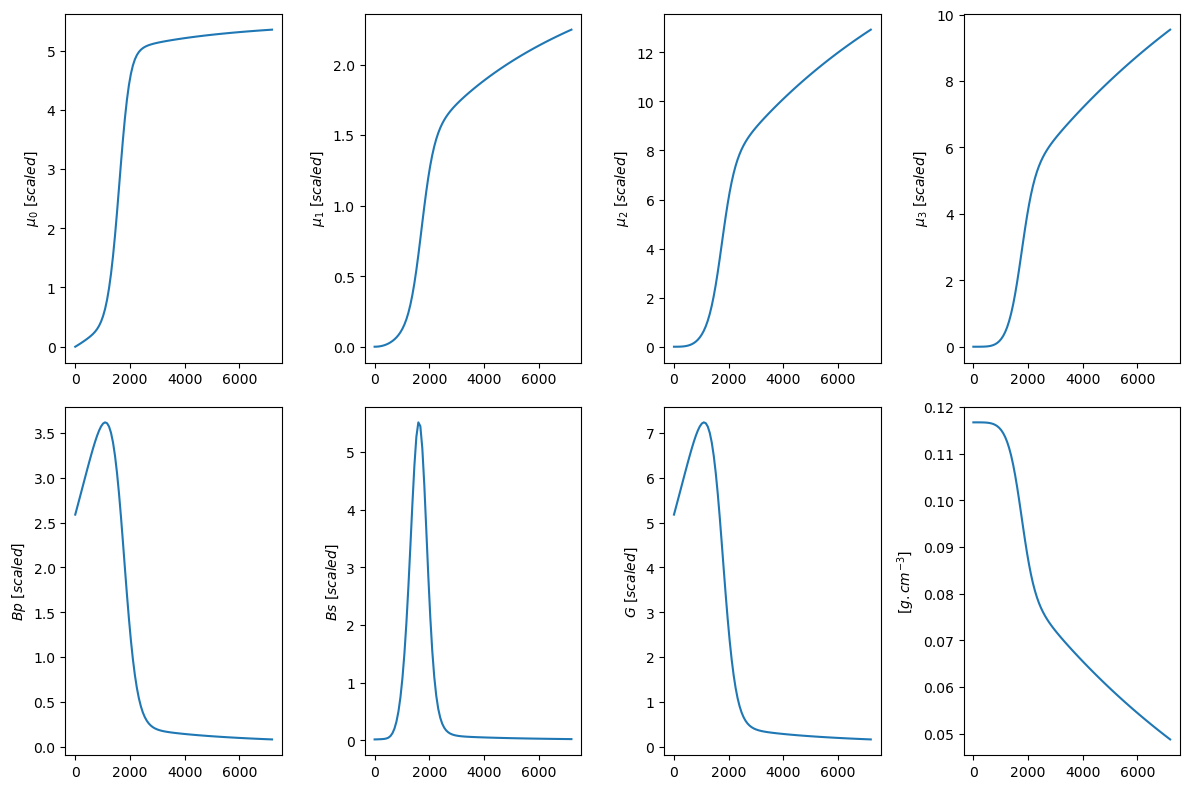

In [6]:
# Simulate results
sim_results = Results(m)
sim_results.load_from_simulator(tsim,profiles)
sim_results.plot(undo_scaling=False)

df = sim_results.to_pandas()

### Temperature profile testing

In [7]:
# Temperature profile testing
Ti      = 323.9     # initial temperature [K]
Te      = 293       # final temperature [K]
n       = 6         # cooling profile order [-]

# Small experiment with Pyomo.DAE
'''
m = pyo.ConcreteModel()

m.t = ContinuousSet(bounds=(0, tau))

m.T = pyo.Var(m.t, initialize = Ti, within = pyo.NonNegativeReals)
# m.mu0 = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
# m.dmu0 = DerivativeVar(m.mu0)

@m.Constraint(m.t)
def temperature(m, t):
    return m.T[t] == Ti - (Ti - Te)*(t / tau)**n

# @m.Constraint(m.t)
# def ode1(m, t):
#     return m.dmu0[t] == 1e12

# m.mu0[0.0].fix(0)


pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=20, scheme='BACKWARD')

pyo.SolverFactory('ipopt').solve(m)

t_values = [t for t in m.t]
# mu0_values = [m.mu0[t]() for t in m.t]
T_values = [m.T[t]() for t in m.t]

plt.plot(t_values, T_values)
plt.show()

'''

"\nm = pyo.ConcreteModel()\n\nm.t = ContinuousSet(bounds=(0, tau))\n\nm.T = pyo.Var(m.t, initialize = Ti, within = pyo.NonNegativeReals)\n# m.mu0 = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)\n# m.dmu0 = DerivativeVar(m.mu0)\n\n@m.Constraint(m.t)\ndef temperature(m, t):\n    return m.T[t] == Ti - (Ti - Te)*(t / tau)**n\n\n# @m.Constraint(m.t)\n# def ode1(m, t):\n#     return m.dmu0[t] == 1e12\n\n# m.mu0[0.0].fix(0)\n\n\npyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=20, scheme='BACKWARD')\n\npyo.SolverFactory('ipopt').solve(m)\n\nt_values = [t for t in m.t]\n# mu0_values = [m.mu0[t]() for t in m.t]\nT_values = [m.T[t]() for t in m.t]\n\nplt.plot(t_values, T_values)\nplt.show()\n\n"

## Numerical Integration with Ipopt

### Discretize

In [8]:
# Discretization using finite difference
# Add an objective. This is helpful for Degeneracy Hunter
m.obj = pyo.Objective(expr=1)

# Discretize the model
# discretizer = pyo.TransformationFactory('dae.collocation')
# discretizer.apply_to(m,nfe=100,scheme='LAGRANGE-RADAU',ncp=3)
pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=100, scheme='BACKWARD')

# Initialize the model using the simulated profile
# https://pyomo.readthedocs.io/en/stable/modeling_extensions/dae.html#from-simulation
sim.initialize_model()

### Check initialization at iteration 0

In [9]:
# Ipopt solver
solver = pyo.SolverFactory('ipopt')
solver.options = {'bound_push':1E-9, 'max_iter':3000, 'linear_solver':'ma57'}

solver.solve(m,tee=True)

Ipopt 3.11.1: bound_push=1e-09
max_iter=3000
linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     5908
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1200

Total number of variables............................:     2012
                     variables with only lower bounds:     1204
               

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 2012, 'Number of variables': 2012, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.4138619899749756}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

### Check Residuals (Optional)

In [10]:
if False:
    # Declare MILP solver (for DH)
    milp_solver = pyo.SolverFactory('cbc')

    # Create Degeneracy Hunter object
    from idaes.core.util.model_diagnostics import DegeneracyHunter
    dh = DegeneracyHunter(m, solver=milp_solver)

    # Print out equations with large residuals at the first iteration
    dh.check_residuals(tol=0.1)

### Plot Results

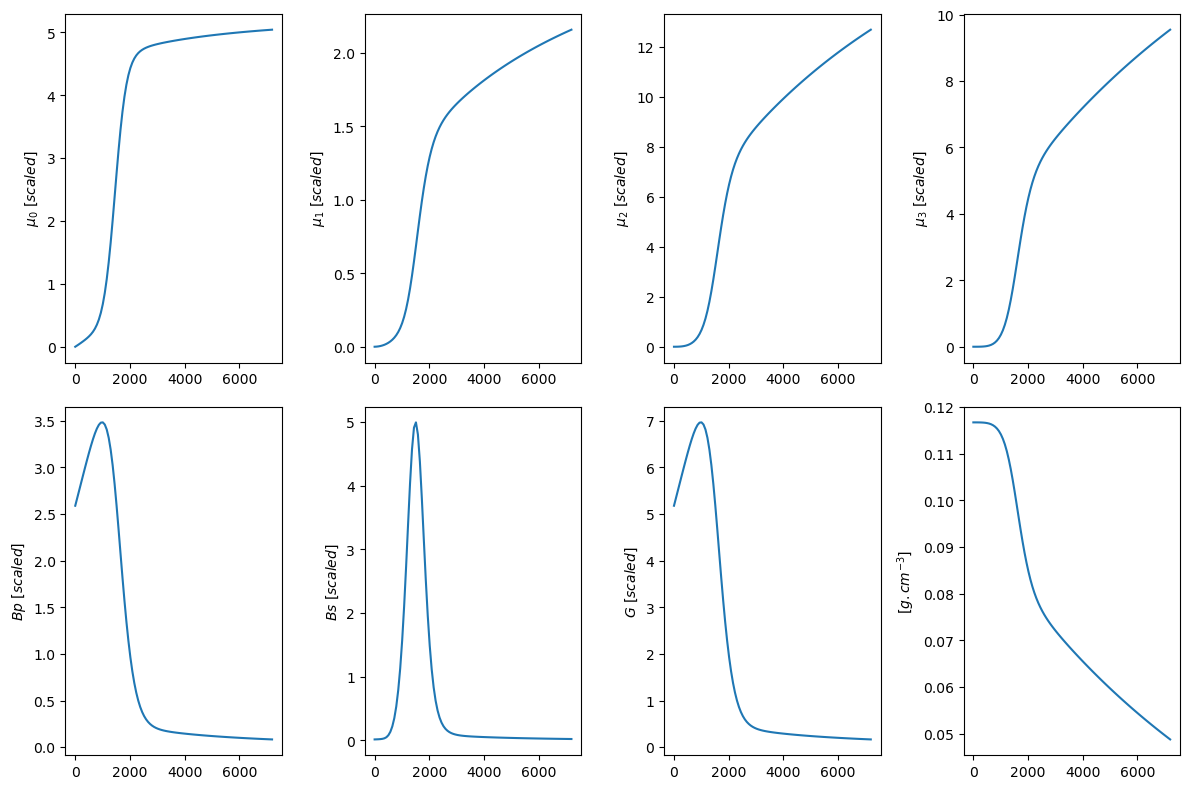

In [11]:
# Plot results
pyo_results = Results(m)
pyo_results.load_from_pyomo_model(m)
pyo_results.plot(undo_scaling=False)
# modify plot function, show data as the dots for the regression (concentration plot with saturation)

## Dynamic Optimization

## Parameter Estimation

### Generate Data

https://ndcbe.github.io/optimization/notebooks/5/Parmest-generate-data.html



In [12]:
# Load in pre-designed experiments

# Full_List   = pd.read_excel('Design of experiments.xlsx', names = ['Ci', 'Ti', 'tau', 'beta', 'eps', 'M_seed', 'Ls'], usecols = "O:U", skiprows = 32, nrows = 42)
Full_List   = pd.read_excel('Design of experiments.xlsx', names = ['Ci', 'Ti', 'tau', 'beta', 'eps', 'M_seed', 'Ls'], usecols = "O:U", skiprows = 34, nrows = 40)

# Scale experimental conditions appropriately
Full_List['Ci']     *= 1e-3
Full_List['eps']    *= 1e-3
Full_List['M_seed'] *= 1e-3
Full_List['Ls']     *= 1e3

Prior_List      = list(range(0, 39, 7))
print(Prior_List)
Prior_Expts     = Full_List.iloc[Prior_List]
# Selection_Pool  = Full_List.drop(Prior_List)

# Restrict Selection_Pool while building out code - decide between few expts
# Selection_Pool  = Full_List.iloc[range(2, 39, 5)]
Selection_Pool  = Full_List.iloc[[6, 17, 28, 36, 39]]

print(len(Prior_Expts), 'prior experiments \n', len(Selection_Pool), 'in Selection Pool' )
Prior_Conditions = Prior_Expts.to_dict(orient='records')
# print(Prior_Conditions)

Selection_Pool = Selection_Pool.to_dict(orient='records')
# print(Selection_Pool)

[0, 7, 14, 21, 28, 35]
6 prior experiments 
 5 in Selection Pool


In [13]:
experiments = []

for i in range(len(Prior_Conditions)):
    exp_i = typical_experiment()
    exp_i['Ci']     = Prior_Conditions[i]['Ci']
    exp_i['Ti']     = Prior_Conditions[i]['Ti']
    exp_i['beta']   = Prior_Conditions[i]['beta']
    exp_i['eps']    = Prior_Conditions[i]['eps']
    exp_i['M_seed'] = Prior_Conditions[i]['M_seed']
    exp_i['Ls']     = Prior_Conditions[i]['Ls']

    experiments.append(exp_i)


In [14]:
from pyomo.opt import SolverStatus, TerminationCondition
list_of_exp_data_frames = []
for i, exp in enumerate(experiments):
    print(Fore.RED + Back.GREEN + "\n***** Considering experiment",i+1," *****")
    print(exp)
    print(Style.RESET_ALL)

    # Create Pyomo model
    expt_selection = False # Use 'true' parameter values
    m = model_theta_switch(exp_conditions=exp)

    # Numerical intergrate to initialize

    # Solve using simulator
    int_ops = {'print_stats':True}
    sim = Simulator(m, package='casadi')
    tsim, profiles = sim.simulate(numpoints=100, integrator = 'idas', integrator_options=int_ops)

    # Discretize
    m.obj = pyo.Objective(expr=1)
    pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=100, scheme='BACKWARD')
    sim.initialize_model()

    # Solve with Ipopt
    solver = pyo.SolverFactory('ipopt')
    solver.options['linear_solver'] = 'ma57'
    solver.solve(m,tee=True)

    

    # Extract results
    results = Results(m)
    results.load_from_pyomo_model(m)

    n = len(results.mu3)
    mu4_div_mu3 = np.zeros(n)
    for i in range(n):
        mu4_div_mu3[i] = results.mu4[i]/(results.mu3[i] + 1e-8)

    # Add noise to data
    def add_noise(vector):
        return np.array(vector) + np.random.normal(0, 0.05*np.std(vector), len(vector))
        # return np.array(vector) + np.random.normal(0, 0.5*np.std(vector), len(vector))


    C_noise     = add_noise(results.C)
    MT_noise    = add_noise(results.MT)
    mu4_div_mu3 = add_noise(mu4_div_mu3)

    Ci = np.ones(n)*exp['Ci']
    Ti = np.ones(n)*exp['Ti']

    df_temp = pd.DataFrame({"time":results.time,"C":C_noise,"MT":MT_noise,"avg_volume":mu4_div_mu3,"Ci":Ci,"Ti":Ti})
    display(df_temp)

    # ============ FIND OUT HOW TO DETECT TERMINATION CONDITION: LOGIC STATEMENT TO ACCEPT/REJECT EXPERIMENTS BASED ON THIS ============
    # print(Fore.GREEN + Back.RED + results.solver.status + results.solver.termination_condition) 
    # print(m.name)
    # print(Style.RESET_ALL)

    list_of_exp_data_frames.append(df_temp)





***** Considering experiment 1  *****
{'Ci': 0.11668498484808734, 'Ti': 323.9, 'tau': 7200, 'beta': 0.0, 'eps': 0.0005, 'M_seed': 0.0024003347464448444, 'Ls': 0.02}

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 386
Number of calls to the user's f function: 590
Number of calls made to the linear solver setup function: 34
Number of error test failures: 5
Method order used on the last internal step: 5
Method order to be used on the next internal step: 5
Actual value of initial step size: 0.000131396
Step size taken on the last internal step: 409.606
Step size to be attempted on the next internal step: 409.606
Current internal time reached: 7200
Number of nonlinear iterations performed: 588
Number of nonlinear convergence failures: 0

Ipopt 3.11.1: linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclip

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.116341,0.002326,0.202053,0.116685,323.9
1,72.0,0.115183,0.004102,0.253281,0.116685,323.9
2,144.0,0.112549,0.006264,0.295482,0.116685,323.9
3,216.0,0.110743,0.008214,0.327786,0.116685,323.9
4,288.0,0.108452,0.010208,0.354205,0.116685,323.9
...,...,...,...,...,...,...
96,6912.0,0.092699,0.026811,0.463951,0.116685,323.9
97,6984.0,0.092823,0.026363,0.464754,0.116685,323.9
98,7056.0,0.092214,0.026240,0.465125,0.116685,323.9
99,7128.0,0.092222,0.026913,0.463685,0.116685,323.9



***** Considering experiment 2  *****
{'Ci': 0.11668498484808734, 'Ti': 315.4, 'tau': 7200, 'beta': 0.0, 'eps': 0.0005, 'M_seed': 0.0005821255453377081, 'Ls': 0.05}

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 407
Number of calls to the user's f function: 651
Number of calls made to the linear solver setup function: 47
Number of error test failures: 10
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 3.15414e-05
Step size taken on the last internal step: 5.98869
Step size to be attempted on the next internal step: 11.9774
Current internal time reached: 7200
Number of nonlinear iterations performed: 649
Number of nonlinear convergence failures: 0

Ipopt 3.11.1: linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Ecli

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.117019,0.000757,0.496845,0.116685,315.4
1,72.0,0.114628,0.002474,0.674030,0.116685,315.4
2,144.0,0.109761,0.008209,0.712784,0.116685,315.4
3,216.0,0.098682,0.018610,0.723872,0.116685,315.4
4,288.0,0.088978,0.028677,0.733585,0.116685,315.4
...,...,...,...,...,...,...
96,6912.0,0.059416,0.058853,0.751095,0.116685,315.4
97,6984.0,0.057708,0.058764,0.751477,0.116685,315.4
98,7056.0,0.058038,0.059149,0.749279,0.116685,315.4
99,7128.0,0.058349,0.059119,0.754401,0.116685,315.4



***** Considering experiment 3  *****
{'Ci': 0.07502559833781035, 'Ti': 307.25, 'tau': 7200, 'beta': 0.0, 'eps': 0.001, 'M_seed': 0.00037429252275727955, 'Ls': 0.05}

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 551
Number of calls to the user's f function: 795
Number of calls made to the linear solver setup function: 45
Number of error test failures: 9
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 1.85925e-05
Step size taken on the last internal step: 39.1722
Step size to be attempted on the next internal step: 78.3445
Current internal time reached: 7200
Number of nonlinear iterations performed: 793
Number of nonlinear convergence failures: 0

Ipopt 3.11.1: linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Ecli

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.074824,0.000781,0.500546,0.075026,307.25
1,72.0,0.072604,0.002784,0.606399,0.075026,307.25
2,144.0,0.066327,0.008745,0.618136,0.075026,307.25
3,216.0,0.057752,0.017880,0.626134,0.075026,307.25
4,288.0,0.050422,0.025324,0.633375,0.075026,307.25
...,...,...,...,...,...,...
96,6912.0,0.037718,0.037689,0.641557,0.075026,307.25
97,6984.0,0.037136,0.037310,0.641747,0.075026,307.25
98,7056.0,0.037764,0.037565,0.640564,0.075026,307.25
99,7128.0,0.037556,0.037984,0.641730,0.075026,307.25



***** Considering experiment 4  *****
{'Ci': 0.03494412532168334, 'Ti': 293.15, 'tau': 7200, 'beta': 0.0, 'eps': 0.0015, 'M_seed': 0.00017433149634220048, 'Ls': 0.1}

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 480
Number of calls to the user's f function: 731
Number of calls made to the linear solver setup function: 46
Number of error test failures: 13
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 5.69528e-06
Step size taken on the last internal step: 23.6488
Step size to be attempted on the next internal step: 47.2976
Current internal time reached: 7200
Number of nonlinear iterations performed: 729
Number of nonlinear convergence failures: 0

Ipopt 3.11.1: linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Ecl

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.034962,0.000243,1.003309,0.034944,293.15
1,72.0,0.033299,0.001940,0.614913,0.034944,293.15
2,144.0,0.029428,0.005645,0.587228,0.034944,293.15
3,216.0,0.025231,0.009857,0.582689,0.034944,293.15
4,288.0,0.021572,0.013158,0.586097,0.034944,293.15
...,...,...,...,...,...,...
96,6912.0,0.017578,0.017477,0.590948,0.034944,293.15
97,6984.0,0.017658,0.017428,0.589168,0.034944,293.15
98,7056.0,0.017241,0.017491,0.589716,0.034944,293.15
99,7128.0,0.017576,0.017564,0.584731,0.034944,293.15



***** Considering experiment 5  *****
{'Ci': 0.03494412532168334, 'Ti': 293.15, 'tau': 7200, 'beta': 0.0, 'eps': 0.0005, 'M_seed': 0.00017433149634220048, 'Ls': 0.15}

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 437
Number of calls to the user's f function: 649
Number of calls made to the linear solver setup function: 49
Number of error test failures: 11
Method order used on the last internal step: 5
Method order to be used on the next internal step: 5
Actual value of initial step size: 9.64435e-06
Step size taken on the last internal step: 75.9551
Step size to be attempted on the next internal step: 151.91
Current internal time reached: 7200
Number of nonlinear iterations performed: 647
Number of nonlinear convergence failures: 0

Ipopt 3.11.1: linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Ecl

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.035071,0.000455,1.493618,0.034944,293.15
1,72.0,0.034674,-0.000154,1.333433,0.034944,293.15
2,144.0,0.034456,0.000640,0.986622,0.034944,293.15
3,216.0,0.032342,0.002428,0.835658,0.034944,293.15
4,288.0,0.029188,0.005296,0.797880,0.034944,293.15
...,...,...,...,...,...,...
96,6912.0,0.017330,0.017127,0.787174,0.034944,293.15
97,6984.0,0.017199,0.017242,0.773109,0.034944,293.15
98,7056.0,0.017707,0.017127,0.780606,0.034944,293.15
99,7128.0,0.017596,0.017114,0.788600,0.034944,293.15



***** Considering experiment 6  *****
{'Ci': 0.11668498484808734, 'Ti': 333.15, 'tau': 7200, 'beta': 0.0035, 'eps': 0.0005, 'M_seed': 0.0, 'Ls': 0.02}

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 903
Number of calls to the user's f function: 1559
Number of calls made to the linear solver setup function: 117
Number of error test failures: 41
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 0.0727273
Step size taken on the last internal step: 48.2927
Step size to be attempted on the next internal step: 48.2927
Current internal time reached: 7200
Number of nonlinear iterations performed: 1557
Number of nonlinear convergence failures: 0

Ipopt 3.11.1: linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public Li

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.117893,0.000463,0.005104,0.116685,333.15
1,72.0,0.117640,-0.001637,0.005637,0.116685,333.15
2,144.0,0.118187,-0.001790,0.018749,0.116685,333.15
3,216.0,0.118579,0.000099,-0.018881,0.116685,333.15
4,288.0,0.113108,-0.000476,-0.016860,0.116685,333.15
...,...,...,...,...,...,...
96,6912.0,0.044992,0.073160,0.902631,0.116685,333.15
97,6984.0,0.040019,0.072372,0.883780,0.116685,333.15
98,7056.0,0.039806,0.076660,0.880815,0.116685,333.15
99,7128.0,0.041902,0.078897,0.885942,0.116685,333.15


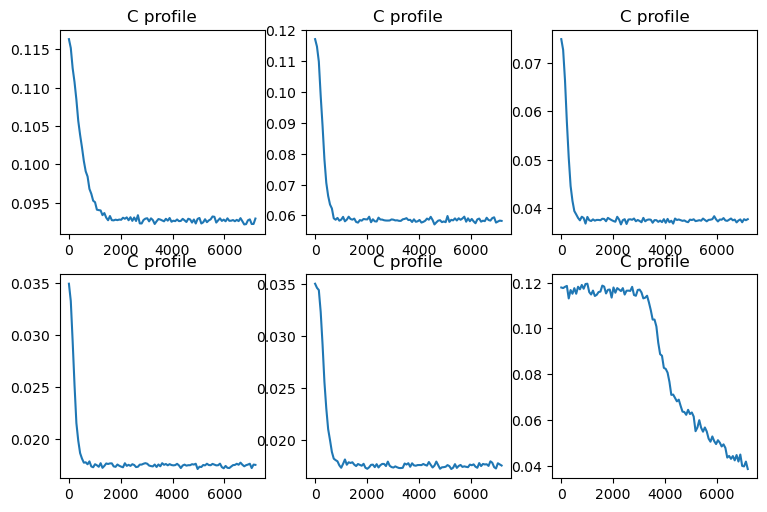

In [15]:
# (Optional) Inspect data from prior experiments - C profiles

fig = plt.figure(figsize=(9, 9))
fig_size = int(np.ceil(np.sqrt(len(Prior_Expts))))

# for i in range(len(Prior_Expts)):
#     x = list_of_exp_data_frames[i]["time"]
#     y = list_of_exp_data_frames[i]["avg_volume"]
#     plt.subplot(fig_size, fig_size, i+1)
#     plt.plot(x,y)
#     plt.title("$\mu_{43}$")


for i in range(len(Prior_Expts)):
    x = list_of_exp_data_frames[i]["time"]
    y = list_of_exp_data_frames[i]["C"]
    plt.subplot(fig_size, fig_size, i+1)
    plt.plot(x,y)
    plt.title("C profile")


### Estimate with Parmest

https://ndcbe.github.io/optimization/notebooks/5/Parmest-tutorial.html

In [17]:
# ========== data dict test ==============

prior_data_prep = []

for i in range(len(Prior_Expts)):
    data_dict_test          = {}
    data_dict_test['Ci']    = list_of_exp_data_frames[i]['Ci'].iloc[0]
    data_dict_test['Ti']    = list_of_exp_data_frames[i]['Ti'].iloc[0]
    
    meas_data = list_of_exp_data_frames[i].drop(labels=['Ci','Ti'],axis=1)

    prior_data_prep.append(meas_data)

# print(type(dataaa))
print(type(prior_data_prep))
# print(np.shape(list_of_exp_data_frames))


<class 'list'>


In [20]:
# Create csv file names for prior experiments
file_list = []

for i in range(len(list_of_exp_data_frames)):
    prior_data_prep[i].to_csv('prior' + str(i), index=False)
    file_list.append('prior' + str(i))

print(file_list)

['prior0', 'prior1', 'prior2', 'prior3', 'prior4', 'prior5']


In [21]:
def create_prior_data_dict(files):
    '''
    Create a list of dictionaries from multiple datasets
    Arguments:
        files: pandas dataframe of file names
    Return:
        data_dict_list: list of dictionaries
    '''
    data_dict_list = []
    for i in range(len(Prior_Expts)):
        # create a dictionary of 'experimental' data for each set of exp conditions
        data_dict   = {}
        data_dict   = Prior_Conditions[i]           # Conditions for experiment
        data_dict['data'] = pd.read_csv(files[i])   # Corresponding exp measurements
        # add dictionary to list to be return
        data_dict_list.append(data_dict)
    return data_dict_list


In [22]:
data_dict_list = []

for i in range(len(Prior_Expts)):
    # create a dictionary of 'experimental' data for each set of exp conditions
    data_dict   = {}
    data_dict   = Prior_Conditions[i]               # Conditions for experiment
    data_dict['data'] = pd.read_csv(file_list[i])   # Corresponding exp measurements
    # add dictionary to list to be return
    data_dict_list.append(data_dict)

print(np.shape(data_dict_list))

(6,)


In [24]:
def Cryst_model_parmest(data):
    '''
    Special create_model function for parmest
    '''

    # Extract measurement data
    exp_data = data['data']

    # temp store for experimental measurements
    c_meas_temp       = exp_data['C']
    mt_meas_temp      = exp_data['MT']
    avg_vol_meas_temp = exp_data['avg_volume']
    t_meas_temp       = exp_data['time']

    # create dictionaries for multiple experimental datasets
    cmeas        = {}
    mtmeas       = {}
    avg_vol_meas = {}
    for i,j in enumerate(t_meas_temp):
        cmeas[float(j)]         = c_meas_temp[i]
        mtmeas[float(j)]        = mt_meas_temp[i]
        avg_vol_meas[float(j)]  = avg_vol_meas_temp[i]

    # New pyomo model for parmest 
    m = pyo.ConcreteModel()

    # Give experimental conditions for each dataset to the model
    m.Ci        = data['Ci']
    m.Ti        = data['Ti']
    m.tau       = data['tau']
    m.beta      = data['beta']
    m.eps       = data['eps']
    m.M_seed    = data['M_seed']
    m.Ls        = data['Ls']

    print(data['Ti']) # flag whether we're using multiple experiments or just one

    # Define timeset from extracted data
    m.t = ContinuousSet(bounds = (0.0, t_meas_temp.iloc[-1]), initialize=t_meas_temp.tolist())

    # define 'experimental' data as Pyomo parameters indexed by timestep set and
    # initialized by dictionary of experimental data
    m.Cmeas         = pyo.Param(m.t, initialize=cmeas)
    m.MTmeas        = pyo.Param(m.t, initialize=mtmeas)
    m.Avg_vol_meas  = pyo.Param(m.t, initialize=avg_vol_meas)


    # Define physical properties & constants
    rho     = 1360 * 1e-6       # crystal density [g.mm-3]
    kv      = 0.523             # volume shape factor
    C1      = 2.209e-6 * 1e-3   # solubility parameter 1 (for g.cm-3)
    C2      = 5.419e-2          # solubility parameter 2

    # Scaling parameters 
    m.mu0_scale      = 1e5
    m.mu1_scale      = 1e4
    m.mu2_scale      = 1e2
    m.mu3_scale      = 1e1
    m.mu4_scale      = 1e0

    m.Bp_scale       = 1e1      # Primary nucl. scaling
    m.Bs_scale       = 1e2      # Seconday nucl. scaling
    m.G_scale        = 1e-5

    ## New Bounds ##
    # m.theta_lb = {'kb1': 1e1, 'b1': 1, 'kb2': 1e6, 'b2': 1, 'kg': 2e-6, 'g': 1}
    m.theta_lb = {'kb1': 1e1, 'b1': 1, 'kb2': 1e8, 'b2': 1, 'kg': 2e-5, 'g': 1}     # RESTRICTED PARAMETER SEARCH RANGE
    # m.theta_ub = {'kb1': 1e4, 'b1': 4, 'kb2': 1e12, 'b2': 5, 'kg': 2e-2, 'g': 3}
    m.theta_ub = {'kb1': 1e3, 'b1': 2, 'kb2': 1e10, 'b2': 3, 'kg': 2e-3, 'g': 2}    # RESTRICTED PARAMETER SEARCH RANGE

    # m.kb1 = pyo.Var(initialize = np.log(m.theta['kb1']), bounds=(np.log(m.theta_lb['kb1']), np.log(m.theta_ub['kb1'])))
    # m.kb2 = pyo.Var(initialize = np.log(m.theta['kb2']), bounds=(np.log(m.theta_lb['kb2']), np.log(m.theta_ub['kb2'])))
    # m.kg  = pyo.Var(initialize = np.log(m.theta['kg']), bounds=(np.log(m.theta_lb['kg']), np.log(m.theta_ub['kg'])))
    
    # m.b1  = pyo.Var(initialize = m.theta['b1'], bounds=(m.theta_lb['b1'], m.theta_ub['b1']))
    # m.b2  = pyo.Var(initialize = m.theta['b2'], bounds=(m.theta_lb['b2'], m.theta_ub['b2']))
    # m.g   = pyo.Var(initialize = m.theta['g'], bounds=(m.theta_lb['g'], m.theta_ub['g']))


    # Kinetic parameters to be fitted defined as Pyomo variables
    if theta_est is not None:   # if we have estimates already; use them
        m.kb1   = pyo.Var(initialize=theta_est['kb1'],  bounds=(1e1,1e3)) 
        m.b1    = pyo.Var(initialize=theta_est['b1'],   bounds=(1,2)) 
        m.kb2   = pyo.Var(initialize=theta_est['kb2'],  bounds=(1e8,1e10)) 
        m.b2    = pyo.Var(initialize=theta_est['b2'],   bounds=(1,3))
        m.kg    = pyo.Var(initialize=theta_est['kg'],   bounds=(2e-5,2e-3)) 
        m.g     = pyo.Var(initialize=theta_est['g'],    bounds=(1,2))
    else:                       # otherwise use these initial guesses
        m.kb1   = pyo.Var(initialize = 5e2,             bounds=(1e1,1e3)) 
        m.b1    = pyo.Var(initialize = 1,               bounds=(1,2)) 
        m.kb2   = pyo.Var(initialize = 2e8,             bounds=(1e8,1e10)) 
        m.b2    = pyo.Var(initialize = 2,               bounds=(1,3))
        m.kg    = pyo.Var(initialize = 3e-4,            bounds=(2e-5,2e-3)) 
        m.g     = pyo.Var(initialize = 1,               bounds=(1,2))


    # Initialize experimental conditions [moments, measureables, growth/nuceleation]
    m.mu0 = pyo.Var(m.t, initialize = m.M_seed / (rho*kv*m.Ls**3)/m.mu0_scale, within = pyo.NonNegativeReals)
    m.mu1 = pyo.Var(m.t, initialize = m.M_seed / (rho*kv*m.Ls**4)/m.mu0_scale, within = pyo.NonNegativeReals)
    m.mu2 = pyo.Var(m.t, initialize = m.M_seed / (rho*kv*m.Ls**5)/m.mu0_scale, within = pyo.NonNegativeReals)
    m.mu3 = pyo.Var(m.t, initialize = m.M_seed / (rho*kv*m.Ls**6)/m.mu0_scale, within = pyo.NonNegativeReals)
    m.mu4 = pyo.Var(m.t, initialize = m.M_seed / (rho*kv*m.Ls**7)/m.mu0_scale, within = pyo.NonNegativeReals)

    m.C       = pyo.Var(m.t, initialize = m.Ci,     within = pyo.NonNegativeReals)
    m.T       = pyo.Var(m.t, initialize = m.Ti,     within = pyo.NonNegativeReals)
    m.MT      = pyo.Var(m.t, initialize = m.M_seed, within = pyo.NonNegativeReals)
    m.avg_vol = pyo.Var(m.t, initialize = m.Ls,     within = pyo.NonNegativeReals)

    m.G     = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    m.Bp    = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    m.Bs    = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)


    # Model Expressions
    # ======= WHY SWAP BETWEEN PARAM AND VAR? =======
    # ======= DO I NEED THIS NOW? =======
    # m.Ci = pyo.Param(m.t, initialize = exp_conditions['Ci'], within = pyo.NonNegativeReals)
    # m.Ti = pyo.Var(m.t, initialize = exp_conditions['Ti'], within = pyo.NonNegativeReals)
    # m.eps = pyo.Param(m.t, initialize = exp_conditions['eps'], within = pyo.NonNegativeReals)
    # m.M_seed = pyo.Var(m.t, initialize = exp_conditions['M_seed'], within = pyo.NonNegativeReals)
    # m.Ls = pyo.Param(m.t, initialize = exp_conditions['Ls'], within = pyo.NonNegativeReals)
    # m.beta = pyo.Var(m.t, initialize = exp_conditions['beta'], within = pyo.NonNegativeReals)

    # Declare Derivative pyo.Variable
    m.dmu0 = DerivativeVar(m.mu0)
    m.dmu1 = DerivativeVar(m.mu1)
    m.dmu2 = DerivativeVar(m.mu2)
    m.dmu3 = DerivativeVar(m.mu3)
    m.dmu4 = DerivativeVar(m.mu4)
    m.dC   = DerivativeVar(m.C)
    m.dMT  = DerivativeVar(m.MT)
    m.dT   = DerivativeVar(m.T)

    '''
    m.kb1 = pyo.Param(initialize = m.theta['kb1'], mutable = True)
    m.b1  = pyo.Param(initialize = m.theta['b1'], mutable = True)
    m.kb2 = pyo.Param(initialize = m.theta['kb2'], mutable = True)
    m.b2  = pyo.Param(initialize = m.theta['b2'], mutable = True)
    m.kg  = pyo.Param(initialize = m.theta['kg'], mutable = True)
    m.g   = pyo.Param(initialize = m.theta['g'], mutable = True)
    '''


    # Do we need to specify: 'mutable = True'?
    # m.kb1 = pyo.Var(initialize = np.log(m.theta['kb1']), bounds=(np.log(m.theta_lb['kb1']), np.log(m.theta_ub['kb1'])), mutable = True)
    # m.kb2 = pyo.Var(initialize = np.log(m.theta['kb2']), bounds=(np.log(m.theta_lb['kb2']), np.log(m.theta_ub['kb2'])), mutable = True)
    # m.kg  = pyo.Var(initialize = np.log(m.theta['kg']), bounds=(np.log(m.theta_lb['kg']), np.log(m.theta_ub['kg'])), mutable = True)
    
    # m.b1  = pyo.Var(initialize = m.theta['b1'], bounds=(m.theta_lb['b1'], m.theta_ub['b1']), mutable = True)
    # m.b2  = pyo.Var(initialize = m.theta['b2'], bounds=(m.theta_lb['b2'], m.theta_ub['b2']), mutable = True)
    # m.g   = pyo.Var(initialize = m.theta['g'], bounds=(m.theta_lb['g'], m.theta_ub['g']), mutable = True)

    # Fix the parameters
    # ================ SHOULD THESE BE FIXED WHEN ESTIMATING? ================
    m.kb1.fix()
    m.b1.fix()
    m.kb2.fix()
    m.b2.fix()
    m.kg.fix()
    m.g.fix()

    alt_rel_sat = True

    def smooth_max(z):
        return 0.5*(pyo.sqrt(z**2+1e-8)+z)

    # Solubility expression
    def solubility(T):
        return C1*pyo.exp(C2*T)

    def inv_solubility(T):
        return pyo.exp(-C2*T)/C1
    

    # Primary and Secondary nucleation separated (for scaling purposes)
    @m.Constraint(m.t)
    def prim_nucl(m, t):
        # Relative supersaturation computation
        if alt_rel_sat:
            rel_sat = m.C[t]*inv_solubility(m.T[t])-1
        else:
            rel_sat = (m.C[t] - solubility(m.T[t]))/solubility(m.T[t])

        # return m.Bp[t] == (m.kb1*smooth_max(rel_sat)**m.b1) / m.Bp_scale
        return m.Bp[t] == (pyo.exp(m.kb1)*smooth_max(rel_sat)**m.b1) / m.Bp_scale

    @m.Constraint(m.t)
    def sec_nucl(m, t):
        # Relative supersaturation computation
        if alt_rel_sat:
            rel_sat = m.C[t]*inv_solubility(m.T[t])-1
        else:
            rel_sat = (m.C[t] - solubility(m.T[t]))/solubility(m.T[t])

        # return m.Bs[t] == (m.kb2*smooth_max(rel_sat)**m.b2)*m.eps[0]*(m.MT[t]) / m.Bs_scale
        return m.Bs[t] == (pyo.exp(m.kb2)*smooth_max(rel_sat)**m.b2)*m.eps[0]*(smooth_max(m.MT[t])) / m.Bs_scale


    @m.Constraint(m.t)
    def growth(m, t):
        # Relative supersaturation computation
        if alt_rel_sat:
            rel_sat = m.C[t]*inv_solubility(m.T[t])-1
        else:
            rel_sat = (m.C[t] - solubility(m.T[t]))/solubility(m.T[t])
        # Growth rate expression
        # return m.G[t] == (m.kg*smooth_max(rel_sat)**m.g) / m.G_scale
        return m.G[t] == (pyo.exp(m.kg)*smooth_max(rel_sat)**m.g) / m.G_scale


    # Constraints for moments and concentration (fixed) for units of mm (L) and mL, or cm^3 (V)
    # @m.Constraint(m.t)
    # def ode1(m, t):
    #     return m.dmu0[t] == m.B[t] * m.B_scale / m.mu0_scale #* m.tau  # Units of # / cm^3 / s

    @m.Constraint(m.t)
    def ode1(m, t):
        return m.dmu0[t] == (m.Bp[t] * m.Bp_scale + m.Bs[t] * m.Bs_scale) / m.mu0_scale #* m.tau  # Units of # / cm^3 / s

    @m.Constraint(m.t)
    def ode2(m, t):
        return m.dmu1[t] == 1 * m.G[t] * m.G_scale * m.mu0[t] * m.mu0_scale / m.mu1_scale #* m.tau  # Units of mm * # / cm^3 / s

    @m.Constraint(m.t)
    def ode3(m, t):
        return m.dmu2[t] == 2 * m.G[t] * m.G_scale * m.mu1[t] * m.mu1_scale / m.mu2_scale #* m.tau  # Units of mm^2 * # / cm^3 / s

    @m.Constraint(m.t)
    def ode4(m, t):
        return m.dmu3[t] == 3 * m.G[t] * m.G_scale * m.mu2[t] * m.mu2_scale / m.mu3_scale #* m.tau  # Units of mm^3 * # / cm^3 / s

    @m.Constraint(m.t)
    def ode5(m, t):
        return m.dmu4[t] == 4 * m.G[t] * m.G_scale * m.mu3[t] * m.mu3_scale / m.mu4_scale #* m.tau  # Units of mm^4 * # / cm^3 / s

    @m.Constraint(m.t)
    def ode6(m, t):
        return m.dC[t] == -3 * kv * rho * m.G[t] * m.G_scale * smooth_max(m.mu2[t]) * m.mu2_scale #* m.tau  # Units of g / cm^3 / s

    # @m.Constraint(m.t)
    # def MT_balance(m, t):
    #     return m.MT[t] == rho * kv * m.mu3[t] * m.mu3_scale # Units of grams.mm-3

    @m.Constraint(m.t)
    def ode7(m, t):
        return m.dMT[t] == 3 * kv * rho * m.G[t] * m.G_scale * smooth_max(m.mu2[t]) * m.mu2_scale # Units of grams.mm-3

    @m.Constraint(m.t)
    def ode8(m, t):
        return m.dT[t] == -m.beta[0] # * m.tau
        # beta[0] is 0 (temperature decay), if we set it to something else we will get something else
        # change beta 0 to something physical
        # (0,(0.5/60))

    @m.Constraint(m.t)
    def average_volume(m,t):
        return (m.mu4[t] + 1e-8) * m.mu4_scale == m.avg_vol[t] * (m.mu3[t] + 1e-8) * m.mu3_scale  # / 1000    Multiplying by 1000 to get in micrometers????
        # return (m.mu1[t] + 1e-8) * m.mu1_scale == m.avg_vol[t] * (m.mu0[t] + 1e-8) * m.mu0_scale


    # Initial conditions (fixed), in units desired (mm and cm^3)
    m.mu0[0.0].fix(m.M_seed[0]/(rho*kv*m.Ls[0]**3)/m.mu0_scale)
    m.mu1[0.0].fix(m.mu0[0.0]*m.mu0_scale*m.Ls[0]/(m.mu1_scale))
    m.mu2[0.0].fix(m.mu0[0.0]*m.mu0_scale*(m.Ls[0])**2/m.mu2_scale)
    m.mu3[0.0].fix(m.mu0[0.0]*m.mu0_scale*(m.Ls[0])**3/m.mu3_scale)
    m.mu4[0.0].fix(m.mu0[0.0]*m.mu0_scale*(m.Ls[0])**4/m.mu4_scale)

    # m.mu0[0.0].fix(m.M_seed/(rho*kv*m.Ls**3)/m.mu0_scale)
    # m.mu1[0.0].fix(m.mu0[0.0]*m.mu0_scale*m.Ls/(m.mu1_scale))
    # m.mu2[0.0].fix(m.mu0[0.0]*m.mu0_scale*(m.Ls)**2/m.mu2_scale)
    # m.mu3[0.0].fix(m.mu0[0.0]*m.mu0_scale*(m.Ls)**3/m.mu3_scale)
    # m.mu4[0.0].fix(m.mu0[0.0]*m.mu0_scale*(m.Ls)**4/m.mu4_scale)

    m.C[0.0].fix(m.Ci[0])
    m.MT[0.0].fix(m.M_seed[0])
    m.T[0].fix(m.Ti[0])

    m.beta[0].fix(m.beta[0])

    # m.C[0.0].fix(m.Ci)
    # m.MT[0.0].fix(m.M_seed)
    # m.T[0].fix(m.Ti)

    # m.beta[0].fix(m.beta[0.0])


    # ## Numerical intergrate to initialize
    # sim = Simulator(m, package='casadi')
    # tsim, profiles = sim.simulate(integrator = 'idas')

    # ## Discretize
    # pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=100,scheme='BACKWARD')
    # sim.initialize_model()
    
    # # Prepare data
    # for i,t in enumerate(data['data'].time):
    #     C_measure[float(t)] = data['data'].C[i]
    #     MT_measure[float(t)] = data['data'].MT[i]
    #     avg_vol_measure[float(t)] = data['data'].avg_volume[i]

    # # print(C_measure)
    # # print(m.C)

    # # Least squares objective

    # def ComputeFirstStageCost_rule(m):
    #     return 0
    # m.FirstStageCost = pyo.Expression(rule=ComputeFirstStageCost_rule)

    # def ComputeSecondStageCost_rule(m):
    #   # measurements
    #     return sum((m.C[t] - C_measure[t]) ** 2 + (m.MT[t] - MT_measure[t]) ** 2
    #                    + (m.avg_vol[t] - avg_vol_measure[t]) ** 2 for t in t_measure)
    #     # return sum((m.C[t] - C_measure[t]) ** 2
    #                   #  + (100 * m.avg_vol[t] - 100 * avg_vol_measure[t]) ** 2 for t in t_measure)
    # m.SecondStageCost = pyo.Expression(rule=ComputeSecondStageCost_rule)

    # # return the sum of the first-stage and second-stage costs as the objective function
    # def total_cost_rule(m):
    #     return m.FirstStageCost + m.SecondStageCost

    # m.total_cost_objective = pyo.Objective(rule=total_cost_rule, sense=pyo.minimize)

    return m

In [ ]:
import pyomo.contrib.parmest.parmest as parmest

# defining the names of the parameters in a list
theta_names = list(m.theta.keys())

# No. datapoints within set
len_data    = len(data_dict_list) * 101 #No. expts * No. timepoints

expt_selection = True   # Set model_theta_switch blind to true parameter values

# create an object using parmest.Estimator() that stores the Pyomo model realizations for the datasets provided.
# This object which will be used to determined the parameter values that best fit all the datasets
pest = parmest.Estimator(Cryst_model_parmest,data_dict_list,theta_names,tee=True,solver_options={'bound_push': 1E-8,
                                                                                                 'halt_on_ampl_error': 'yes',#})
                                                                                                 'linear_solver': 'ma97',
                                                                                                 'max_iter':500})


# call the method theta_est() for the Estimator() object defined above to solve
# the parameter estimation problem.
# theta_est() returns:
    # the overall objective function value
    # estimated parameter values (dictionary with keys = parameters names as defined in the Pyomo model)

theta_est = None    # No estimates yet: define as None for logic statement
obj, theta = pest.theta_est()

print('theta:\n',theta)
print(np.shape(list_of_exp_data_frames))

In [ ]:
# Extracting un-scaled values of theta from parmest
theta_est = {'kb1': np.exp(theta[0]), 'b1': theta[1], 'kb2': np.exp(theta[2]), 'b2': theta[3], 'kg': np.exp(theta[4]),'g': theta[5]}
print(theta)
print(theta_est)
theta_est_list = []
theta_est_list.append(theta_est)

In [ ]:
# Define DoE object parameters ---> tidy up later 

#=====================================================================
# Gather time points you want. Probably can specify from the model(??)
time_control = []
old_div = -1
for i in range(51):
    if int(i * 144 / 900) != old_div:
      old_div = int(i * 144 / 900)
      time_control.append(i * 144)
print(time_control)
# Defining the control time set (hours)
#time_control = [0, 0.25, 0.50, 0.75, 1]
# m.theta_lb = {'kb1': 1e1, 'b1': 1, 'kb2': 1e6, 'b2': 1, 'kg': 2e-6, 'g': 1}
# param_lb = {'kb1': 1e1, 'b1': 1, 'kb2': 1e6, 'b2': 1, 'kg': 2e-6, 'g': 1}
# Defining parameter nominal value
# parameter_dict = {'kb1':10,'b1':0.1,'kb2':100,'b2': 0.2, 'kg': 0.00002, 'g': 0.54641}
parameter_dict = dict(theta)
# move to adhere with bounds
# parameter_dict['kb1'] *= 1.03
# parameter_dict['b1'] *= 0.97
# parameter_dict['kb2'] *= 1.03
# parameter_dict['b2'] *= 1.03

# for key in parameter_dict.keys()
#   parameter_dict[key]
# parameter_dict = {k:v*1.01 for (k, v) in parameter_dict
#============================================================================
# Defining measurements (physically measuring -- need to change)
measurement_class = MeasurementVariables()
variable_name='C'
#sum((m.C[t] - C_measure[t]) ** 2 + (m.MT[t] - MT_measure[t]) ** 2
 #                      + (m.avg_vol[t] - avg_vol_measure[t]) ** 2 for t in t_measure)
indices = {0:time_control}
# Adding measurements variables
measurement_class.add_variables('C',indices=indices, time_index_position=0,variance=1e-1*0.05)
measurement_class.add_variables('MT',indices=indices, time_index_position=0,variance=1e-1*0.05)
measurement_class.add_variables('avg_vol',indices=indices, time_index_position=0,variance=1e-3)
# print('Measurement names:', measurement_class.variable_names
# Design variables (manipulate to make experiment more informative -- Ci is fine for now)
design_vars = DesignVariables()

var_C = 'Ci'
# var_C = 'C'
indices_C = [0, ]
exp1_C = [95e-3,] 
var_T = 'Ti'
indices_T = {0:[0]}
exp1_T = [325, ]
design_vars.add_variables(var_T, indices = indices_T, time_index_position=0, values=exp1_T,
                          lower_bounds=293.15, upper_bounds=333.15)  
print("Design variable names:", design_vars.variable_names)
# Sensitivity selection
# sensitivity_option = 'sequential_finite'
sensitivity_option = 'direct_kaug'
# Define experiments
design_names = design_vars.variable_names
control_time = [0]
exp1 = (control_time, 325)
# exp1 = 
# exp1_design_dict = dict(zip(design_names, exp1)
# print(exp1_design_dict)
print(exp1)
# design_vars.update_values(exp1_design_dict
#=========================================================================


In [ ]:
def disc_for_measure(m, nfe=50, block=True):
    """
    Pyomo.DAE discretization

    Arguments
    ---------
    m: Pyomo model
    nfe: number of finite elements b
    block: if True, the input model has blocks
    """
    # Discretization using collocation
    discretizer = pyo.TransformationFactory("dae.finite_difference")
    # nfe = 50
    # discretizer = pyo.TransformationFactory("dae.collocation")
    if block:
        for s in range(len(m.block)):
            discretizer.apply_to(m.block[s], nfe=nfe, wrt=m.block[s].t, scheme='BACKWARD')
            sim = Simulator(m.block[s], package='casadi')
            # discretizer.apply_to(m.block[s], nfe=nfe, ncp=3, wrt=m.block[s].t, scheme='LAGRANGE-RADAU')
            tsim, profiles = sim.simulate(numpoints=150, integrator = 'idas', integrator_options=int_ops)
            sim.initialize_model()
    else:
        # TODO: Add simulation to this case
        discretizer.apply_to(m, nfe=nfe, wrt=m.t, scheme='BACKWARD')
        # discretizer.apply_to(m.block[s], nfe=nfe, ncp=6, wrt=m.block[s].t, scheme='LAGRANGE-RADAU')
    return m

In [ ]:
sensitivity_option = 'direct_kaug'
# sensitivity_option = 'sequential_finite'
solver.options = {'bound_push':1E-8, 'max_iter':3000,'linear_solver': 'ma57'}

expt_selection = True           # Use estimated parameter set

doe_object = DesignOfExperiments(parameter_dict, # dictionary of parameters
design_vars,       # design variables
measurement_class, # measurements
model_theta_switch,# model           ========================== *should be model with theta_est, yes? ==========================
# Cryst_model,     # true model      ========================== wrong? ==========================
solver = solver,   # solver option
discretize_model = disc_for_measure)

# Compute FIM
result = doe_object.compute_FIM(mode = sensitivity_option, # sensitivity option
FIM_store_name = 'dynamic.csv', # FIM results
read_output = None,             # output
scale_nominal_param_value=True, # scaling
formula = "central")            # central finite difference

result.result_analysis()

In [ ]:
cov_est = [] # Create list: covariance matrix for each parameter estimation
det_est = [] # Create list: det(cov) for each cov. matrix

cov_est.append(np.linalg.inv(result.FIM))       # Get covariance matrix of initial parameter set estimation
det_est.append(scipy.linalg.det(cov_est[0]))    # Get det(cov) which indicates volume of combined confidence ellipsoid
print(det_est)

In [ ]:
# direct_kaug gives ellipse volume of -2e+60
# sequential_finite gives volume of   +1e-38

# ---> test k_aug in practice: we're using the relative change in det() value, so might still be representative???? 
# ---> (ask about this)

In [ ]:
experiments = []

for i in range(len(Selection_Pool)):
# for i in range(1):
    exp_i = typical_experiment()
    exp_i['Ci']     = Selection_Pool[i]['Ci']
    exp_i['Ti']     = Selection_Pool[i]['Ti']
    exp_i['beta']   = Selection_Pool[i]['beta']
    exp_i['eps']    = Selection_Pool[i]['eps']
    exp_i['M_seed'] = Selection_Pool[i]['M_seed']
    exp_i['Ls']     = Selection_Pool[i]['Ls']

    experiments.append(exp_i)


In [ ]:
# Loop over experiments in selection pool - use simulated data to get FIM

opt_criteria        = []                # List to contain the optimality criteria of selected experiments
expt_chosen         = []                # List to contain experimental conditions of selected experiments

No_expts            = len(experiments)  # No. of experiments to add to experimental campaign

# Loop to perform identified 'optimal' experiments and update parameter estimation - do this 'No_expts' times
# for j in range(No_expts):
for j in range(2): 
    print(Fore.GREEN + Back.RED)
    print("\n***** LOOP NO.",j+1," *****")
    print(Style.RESET_ALL)
    
    sim_exp_data_frames = []            # Create/reset store of simulated experimental results
    Selection_FIM       = []            # List to contain the FIM of experiments in selection pool

    # Loop to identify 'optimal' experiment using simulations of experiments in selection pool
    for i, exp in enumerate(experiments): 

        # =============== Simulate candidate experiments ===============
        print(Fore.RED + Back.GREEN + "\n***** Considering experiment",i+1," *****")
        print(exp)
        print(Style.RESET_ALL)

        # Create Pyomo model
        expt_selection = True           # Use theta_est: simulation of experimental results based on current kinetic parameter estimates
        m = model_theta_switch(exp_conditions=exp)

        # Numerical intergrate to initialize

        # Solve using simulator
        int_ops = {'print_stats':True}
        sim = Simulator(m, package='casadi')
        tsim, profiles = sim.simulate(numpoints=100, integrator = 'idas', integrator_options=int_ops)

        # Discretize
        m.obj = pyo.Objective(expr=1)
        pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=100, scheme='BACKWARD')
        sim.initialize_model()

        # Solve with Ipopt
        solver = pyo.SolverFactory('ipopt')
        solver.options = {'bound_push':1E-7, 'max_iter':2500,'linear_solver': 'ma57', 'halt_on_ampl_error': 'yes'}
        solver.solve(m,tee=True)

        # Extract results
        results = Results(m)
        results.load_from_pyomo_model(m)

        n = len(results.mu3)
        mu4_div_mu3 = np.zeros(n)
        for i in range(n):
            mu4_div_mu3[i] = results.mu4[i]/(results.mu3[i] + 1e-8)

        Ci = np.ones(n)*exp['Ci']
        Ti = np.ones(n)*exp['Ti']

        # create df of results
        df_temp = pd.DataFrame({"time":results.time,"C":results.C,"MT":results.MT,"avg_volume":mu4_div_mu3, "Ci":Ci,"Ti":Ti})
        display(df_temp)

        # store results from each simulation
        sim_exp_data_frames.append(df_temp)

        # create a list of prior data results with results of current simulation
        sim_data_for_FIM = list_of_exp_data_frames
        sim_data_for_FIM.append(df_temp)

        # =============== Calculate FIM ===============

        # Ipopt solver
        solver = pyo.SolverFactory('ipopt')

        # solver.options = {'bound_push':1E-6, 'max_iter':3000,'linear_solver': 'ma57'} # Simulation of experiments *generally* fine (0,1,15 are out), but FIM terminates in 'unknown' state
        solver.options = {'bound_push':1E-7, 'max_iter':3000,'linear_solver': 'ma57'}

        # DoE object
        
        expt_selection = True                               # Use parameter set theta_est in simulation of selection pool experiments

        doe_object = DesignOfExperiments(parameter_dict,    # dictionary of parameters
                                         design_vars,       # design variables
                                         measurement_class, # measurements
                                         model_theta_switch,# model           ========================== *should be model with theta_est, yes? ==========================
                                        #  Cryst_model,       # model         ========================== wrong? ==========================
                                         solver = solver,   # solver option
                                         discretize_model = disc_for_measure  # discretization
                                         )

        # Compute FIM
        result = doe_object.compute_FIM(mode = sensitivity_option,      # sensitivity option
                                        FIM_store_name = 'dynamic.csv', # FIM results
                                        read_output = None,             # output
                                        scale_nominal_param_value=True, # scaling
                                        formula = "central"             # central finite difference
                                        )

        # FIM results
        result.result_analysis()

        print('======Results Summary======')
        print('Four design criteria log10() value:')
        print('A-optimality:', np.log10(result.trace))
        print('D-optimality:', np.log10(result.det))
        print('E-optimality:', np.log10(result.min_eig))
        print('Modified E-optimality:', np.log10(result.cond))
        print(result.FIM)

        Selection_FIM.append(result.FIM)


    # =============== Identify optimal experiment ===============

    # Reset d_opt list each loop
    d_opt = []
    
    # Determine optimality criterion values for each experiment
    for i in range(len(Selection_FIM)):
        d_opt.append(scipy.linalg.det(Selection_FIM[i]))
        # print(scipy.linalg.det(Selection_FIM[i].FIM))
    
    # Determine optimal experiment choice 
    opt_choice = pd.Series(d_opt).idxmax()
    print('\n', opt_choice)
    print('optimal experiment is:')
    print(Selection_Pool[opt_choice])

    # =============== 'Execute' optimal experiment ===============

    print(Fore.GREEN + Back.RED)
    print("\n***** Performing Optimal Experiment  *****")
    print(Style.RESET_ALL)

    # Create Pyomo model
    expt_selection = False                                              # Use 'true' parameter values
    m = model_theta_switch(exp_conditions=Selection_Pool[opt_choice])   # Perform optimal experiment
    # Numerical intergrate to initialize
    # Solve using simulator
    int_ops = {'print_stats':True}
    sim = Simulator(m, package='casadi')
    tsim, profiles = sim.simulate(numpoints=100, integrator = 'idas', integrator_options=int_ops)
    # Discretize
    m.obj = pyo.Objective(expr=1)
    pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=100, scheme='BACKWARD')
    sim.initialize_model()
    # Solve with Ipopt
    solver = pyo.SolverFactory('ipopt')
    solver.options['linear_solver'] = 'ma57'
    solver.solve(m,tee=True)
    # Extract results
    results = Results(m)
    results.load_from_pyomo_model(m)
    
    n = len(results.mu3)
    mu4_div_mu3 = np.zeros(n)
    for i in range(n):
        mu4_div_mu3[i] = results.mu4[i]/(results.mu3[i] + 1e-8)

    C_noise     = add_noise(results.C)                                  # Add noise to experimental measurements
    MT_noise    = add_noise(results.MT)                                 # Add noise to experimental measurements
    mu4_div_mu3 = add_noise(mu4_div_mu3)                                # Add noise to experimental measurements
    Ci = np.ones(n)*exp['Ci']
    Ti = np.ones(n)*exp['Ti']
    df_temp = pd.DataFrame({"time":results.time,"C":C_noise,"MT":MT_noise,"avg_volume":mu4_div_mu3,"Ci":Ci,"Ti":Ti})
    display(df_temp)
    list_of_exp_data_frames.append(df_temp)

    print(np.shape(list_of_exp_data_frames))
    
    # =====================================================

    print(Fore.GREEN + Back.RED)
    print("\n***** Updating Parameter Estimates Using New Data  *****")
    print(Style.RESET_ALL)

    obj, theta = pest.theta_est()
    
    theta_est = {'kb1': np.exp(theta[0]), 'b1': theta[1], 'kb2': np.exp(theta[2]), 'b2': theta[3], 'kg': np.exp(theta[4]),'g': theta[5]}
    print(theta)
    print(theta_est)
    theta_est_list.append(theta_est)
    
    # =====================================================
    
    del(Selection_Pool[opt_choice])

    cov_est.append(np.linalg.inv(result.FIM))       # Get covariance matrix of initial parameter set estimation
    det_est.append(scipy.linalg.det(cov_est[0]))    # Get det(cov) which indicates volume of combined confidence ellipsoid
    
print(Fore.BLACK + Back.WHITE)
print("\n***** Confidence Ellipsoid Volume  *****")
print(Style.RESET_ALL)

print(det_est)

In [ ]:
d_opt[opt_choice]
print(opt_choice)
print(det_est)
print(theta_est_list)
print(np.shape(list_of_exp_data_frames))

In [ ]:
# (Optional) Inspect data from prior experiments - C profiles

fig_size = int(np.ceil(np.sqrt(len(Selection_Pool))))
fig = plt.figure(figsize=(fig_size*4, fig_size*4))

for i in range(len(Selection_Pool)):
    x = sim_exp_data_frames[i]["time"]
    # y = sim_exp_data_frames[i]["avg_volume"]
    y = sim_exp_data_frames[i]["C"]
    plt.subplot(fig_size, fig_size, i+1)
    plt.plot(x,y)
    # plt.title("\mu_43")
    plt.title("C profile")

print(Selection_Pool)


In [ ]:
# (Optional) Inspect data from prior experiments - C profiles

fig_size = int(np.ceil(np.sqrt(np.shape(list_of_exp_data_frames)[0])))
fig = plt.figure(figsize=(fig_size*3, fig_size*3))

for i in range(np.shape(list_of_exp_data_frames)[0]):
    x = list_of_exp_data_frames[i]["time"]
    y = list_of_exp_data_frames[i]["C"]
    plt.subplot(fig_size, fig_size, i+1)
    plt.plot(x,y)
    plt.title("C profile")
